<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Numerical methods: 11. Finite differences
## Diffusion equation in 1D
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve a simple **transient diffusion equation** in one dimension,
using different numerical methods.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The general advection-diffusion-reacton equation from the last part reads:
$$\fbox{$
\frac{\partial c}{\partial t}
= - v \frac{dc}{dx}
+ D \frac{d^2c}{dx^2}
+ R
$}$$

----
## Diffusion

We start defining the transient diffusion equation. We describe a quantity $c(x,t)$ in an incompressible fluid,
which changes its position only through diffusion of the particle quantity:
$$
\fbox{$
\frac{\partial c(x,t)}{\partial t} - D \frac{\partial^2 c(x,t)}{\partial x^2} = 0
$}
$$
with
$x$ [m] the position,
$t$ [s] time,
$D$ [m$^2$/s] the diffusivity, and
$\Delta t$ [s] the time increment.

The transient advection equation is a **hyperbolic partial differential equation**, which has a unique
solution for the **initial condition**:
$$
c(x,t=0) = c_0(x,0)
$$

----
## Gaussian function

We define the `Gaussian` function with mean $\mu$ and standard deviation $\sigma$:
$$
c(x,t) = e^{-\frac{(x-\mu)^2}{\sigma^2}}
$$
which is a solution of the transient diffusion equation.


In [2]:
def gaussian(x,mu=5.,sigma=1.):
    f = np.exp(-(x-mu)**2/(sigma)**2)
    return f

In [3]:
xstep = 101
x,dx = np.linspace(0,10,xstep,retstep=True) # m

In [ ]:
u0 = gaussian(x)

plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.fill_between(x,u0,0,label='t = 0 s',linewidth=2,edgecolor=(0,0.2,1,1.0), facecolor=(0,0.2,1,.2))
plt.legend()

----
## Numerical solution methods

Next, we derive several numerical methods, which can be used to solve the transient advection equation.
We first need to assign the temporal and spatial time steps, $\Delta t$ [s] and $\Delta x$ [m], 
the velocity $v$ [m/s], and the diffusivity $D$ [m$^2$/s]:

Thus we have discretised both spatial and temporal variables:
$$
\begin{array}{rcl}
t_n &=& t_0 + n \Delta T, \quad n=0,N \\
x_i &=& x_0 + i \Delta x, \quad i=0,I
\end{array}
$$

The `Courant number`, defined as
$$
Co = \frac{D \Delta t}{\Delta x^2}
$$
defines the stability of the numerical solutions. Explicit solutions are stable
for $Co <1$.

We solve for the time increment:
$$
\Delta t < \frac{\Delta x^2}{D}
$$

In [4]:
v  = 0.0   # m/s
D  = 0.3   # m2/s
dt = dx**2/D
print ('Courant time step: ',dt)
dt = 0.2*dt
print ('Courant time step with savety margin: ',dt)

Courant time step:  0.03333333333333334
Courant time step with savety margin:  0.006666666666666668


In [5]:
time = np.arange(0,8,dt)
print(time.shape)

(1200,)


----
## FTCS explicit scheme (forward time centered space)

Our first scheme is called `FTCS`, forward time, centered space, thus the derivatives in the
transient advection equations are replaced by **forward differences in time** and 
**central differences is space**:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
D \frac{c_{i+1}^{n}-2 c_{i}^{n} + c_{i-1}^{n}}{\Delta x^2}
$$
or solved for the next time step
$$
c_{i}^{n+1}
=
\left( 1-2\alpha \right) c_{i}^{n} 
+ \alpha \left( c_{i+1}^{n} + c_{i-1}^{n} \right)
$$
with
$$
\alpha = D \frac{\Delta t}{\Delta x^2}
$$

<img src="images/PDE_FTCSexplicit.jpg" style="height:5cm;">

We implement the FTCS explicit method:

In [6]:
nt = time.shape[0]
nx = x.shape[0]
U = np.zeros(nt*nx).reshape(nx,nt)
u = np.zeros(nx)
print(U.shape)
# initial step
U[:,0] = gaussian(x)
alpha = D*dt/dx/dx
# time iteration
for n in range(1,time.shape[0]):
    uold = U[:,n-1]
    for i in range(1,u.shape[0]-1):
        u[i] = (1-2*alpha)*uold[i] + alpha*(uold[i+1]+uold[i-1])
    U[:,n] = u

(101, 1200)


[5.] [1.]
[5.] [0.74526421]
[5.] [0.62010043]
[5.] [0.54226994]
[5.] [0.48790584]
[5.] [0.44717786]
[5.] [0.41519778]
[5.] [0.38922427]
[5.] [0.36758486]
[5.] [0.34919296]
[5.] [0.33330698]
[5.] [0.31940011]


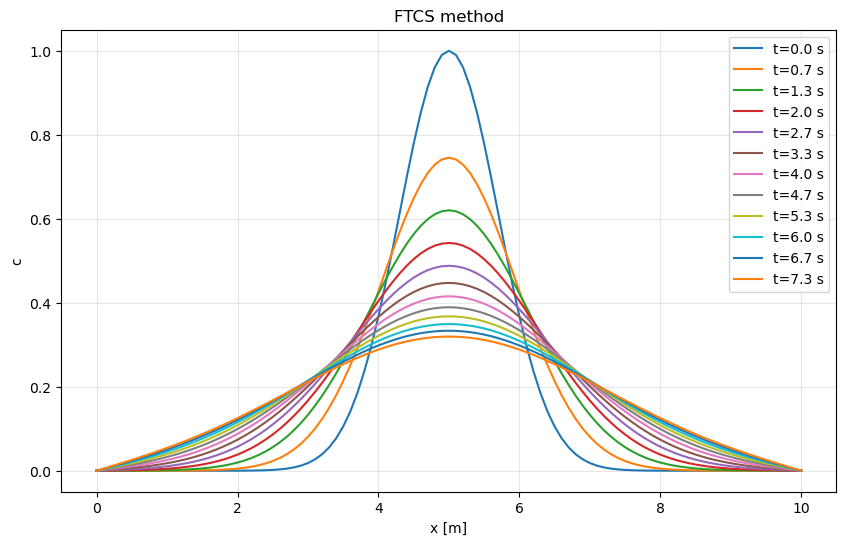

In [7]:
plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.title('FTCS method')
for j in range(0,U.shape[1],100):
    print(x[np.where(U[:,j] == np.amax(U[:,j]))],U[:,j][np.where(U[:,j] == np.amax(U[:,j]))])
    plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
plt.legend()

----
## DuFort-Frankel scheme

Our second scheme is the `DuFort-Frankel scheme`, which reads:
$$
\frac{c_{i}^{n+1}-c_{i}^{n-1}}{2 \Delta t}
=
D \frac{c_{i+1}^{n}-2 \frac{c_{i}^{n+1} + c_{i}^{n-1}}{2} + c_{i-1}^{n}}{\Delta x^2}
$$
or solved for the next time step
$$
c_{i}^{n+1}
=
\frac{1-\alpha'}{1+\alpha'} c_{i}^{n-1} 
+ \frac{\alpha'}{1+\alpha'} \left( c_{i+1}^{n}+c_{i-1}^{n} \right)
$$
with
$$
\alpha' = 2 D \frac{\Delta t}{\Delta x}
$$
Note that we need **two older time steps**, $c_{i}^{n}$ and $c_{i}^{n-1}$!
We therefore use the FTCS explicit method for the first time step generation...

<img src="images/PDE_DuFord_Frankel.jpg" style="height:5cm;">

We implement the DuFort-Frankel method:

In [ ]:
nt = time.shape[0]
nx = x.shape[0]
U = np.zeros(nt*nx).reshape(nx,nt)
u = np.zeros(nx)
print(U.shape)
# initial step
U[:,0] = gaussian(x)
alpha = D*dt/dx/dx

# first step with FTCS explicit
uold = U[:,0]
for i in range(1,u.shape[0]-1):
    u[i] = (1-2*alpha)*uold[i] + alpha*(uold[i+1]+uold[i-1])
U[:,1] = u

# sub-sequent steps with DuFord-Frankel
alphap = D*dt/dx/dx
for n in range(2,time.shape[0]):
    uveryold = uold
    uold = U[:,n-1]
    for i in range(1,u.shape[0]-1):
        u[i] = (1-alphap)/(1+alphap)*uveryold[i] + alphap/(1+alphap) * (uold[i+1]+uold[i-1])
    U[:,n] = u

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.title('DuFort-Frankel method')
for j in range(0,U.shape[1],100):
    print(x[np.where(U[:,j] == np.amax(U[:,j]))],U[:,j][np.where(U[:,j] == np.amax(U[:,j]))])
    plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
plt.legend()

----
## Crank-Nicolson method

Our third scheme is called `Crank-Nicolson method`, which is an **implicit** method:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
D \frac{
\left( c_{i+1}^{n+1} - 2 c_{i}^{n+1} + c_{i-1}^{n+1} \right) +
\left( c_{i+1}^{n} - 2 c_{i}^{n} + c_{i-1}^{n} \right)
}{2 \Delta x^2}
$$
With
$\alpha=\frac{D \Delta t}{\Delta x^2}$, we can recast the equation into a system of linear equations:
$$
-\alpha c_{i+1}^{n+1} + 2 (1+\alpha) c_{i}^{n+1} -\alpha c_{i-1}^{n+1}
=
\alpha c_{i+1}^{n} + 2 (1-\alpha) c_{i}^{n} +\alpha c_{i-1}^{n}
$$
The right-hand side is known, thus we have a tridiagonal linear system:
$$
\mathbf{A} \mathbf{c} = \mathbf{b}
$$

<img src="images/PDE_Crank_Nicolson.jpg" style="height:5cm;">

We implement the Crank-Nicholson method:

In [8]:
nt = time.shape[0]
nx = x.shape[0]
U = np.zeros(nt*nx).reshape(nx,nt)
u = np.zeros(nx)
print(U.shape)
# initialise matrix A and rhs vector b
A = np.zeros(len(u)*len(u)).reshape(len(u),len(u))
b = np.zeros(len(u))
print(A.shape)
print(b.shape)
# initial step
U[:,0] = gaussian(x)
alpha = D*dt/dx/dx

# time iteration
for n in range(1,time.shape[0]):
    uold = U[:,n-1]
    for i in range(len(u)):
        # fill matrix
        if (i != 0):
            A[i,i-1] = - alpha
        A[i,i]   = + 2*(1+alpha)
        if (i != len(u)-1):
            A[i,i+1] = - alpha
        # fill rhs vector  
        b[i] = 2*(1-alpha)*uold[i]
        if (i != 0):
            b[i] = b[i] + alpha*uold[i-1]
        if (i != len(u)-1):
            b[i] = b[i] + alpha*uold[i+1]
    # solve linear sytem
    u = np.linalg.solve(A,b)
    U[:,n] = u

(101, 1200)
(101, 101)
(101,)


[5.] [1.]
[5.] [0.74581588]
[5.] [0.62054087]
[5.] [0.54260788]
[5.] [0.48817153]
[5.] [0.44739264]
[5.] [0.41537562]
[5.] [0.38937455]
[5.] [0.36771419]
[5.] [0.34930644]
[5.] [0.33340912]
[5.] [0.31949545]


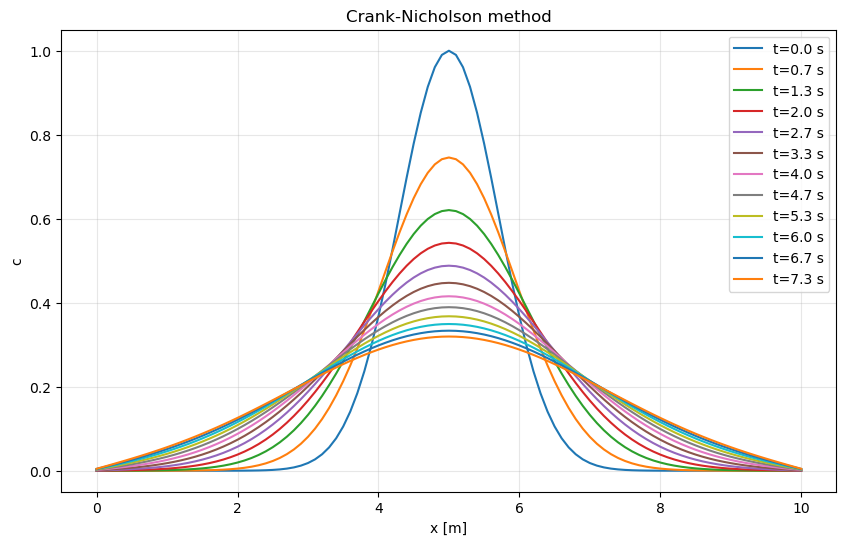

In [9]:
plt.figure(figsize=(10,6))
plt.xlabel('x [m]')
plt.ylabel('c')
plt.grid(alpha=0.3)
plt.title('Crank-Nicholson method')
for j in range(0,U.shape[1],100):
    print(x[np.where(U[:,j] == np.amax(U[:,j]))],U[:,j][np.where(U[:,j] == np.amax(U[:,j]))])
    plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
plt.legend()

... done